In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from joblib import dump, load

In [2]:
sns.set_style("whitegrid")

In [43]:
train = pd.read_csv("data/with_outliers_and_uncorrelated/train_cleaned.csv")
test = pd.read_csv("data/with_outliers_and_uncorrelated/test_cleaned.csv")

In [4]:
def model_train_and_tune(model, param_grid, X_train, y_train, random_search=False):
    if random_search:
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1, verbose=2)
    else:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    return grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [5]:
def print_results(score, params):
    print(f"Best score: {score}")
    print(f"Best params: {params}")

In [6]:
def custom_auc_score(y_true, y_pred_prob):
    roc_auc_scores = []
    for i in range(y_pred_prob.shape[1]):
        y_true_i = np.where(y_true == i, 1, 0)
        roc_auc_scores.append(roc_auc_score(y_true_i, y_pred_prob[:, i]))
    return np.mean(roc_auc_scores)

In [7]:
weights = {
    0: 19219 / 4761 / 8,
    1: 19219 / 485 / 8,
    2: 19219 / 3431 / 8,
    3: 19219 / 818 / 8,
    4: 19219 / 6540 / 8,
    5: 19219 / 1466 / 8,
    6: 19219 / 568 / 8,
    7: 19219 / 1150 / 8
}

In [44]:
train.columns

Index(['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter',
       'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity',
       'Length_of_Conveyer', 'TypeOfSteel_A300', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'defect'],
      dtype='object')

In [45]:
train = train.drop(columns=["Maximum_of_Luminosity", "Square_Index", "Edges_X_Index", "Outside_Global_Index", "Luminosity_Index"])
test = test.drop(columns=["Maximum_of_Luminosity", "Square_Index", "Edges_X_Index", "Outside_Global_Index", "Luminosity_Index"])

In [46]:
train.shape

(19219, 20)

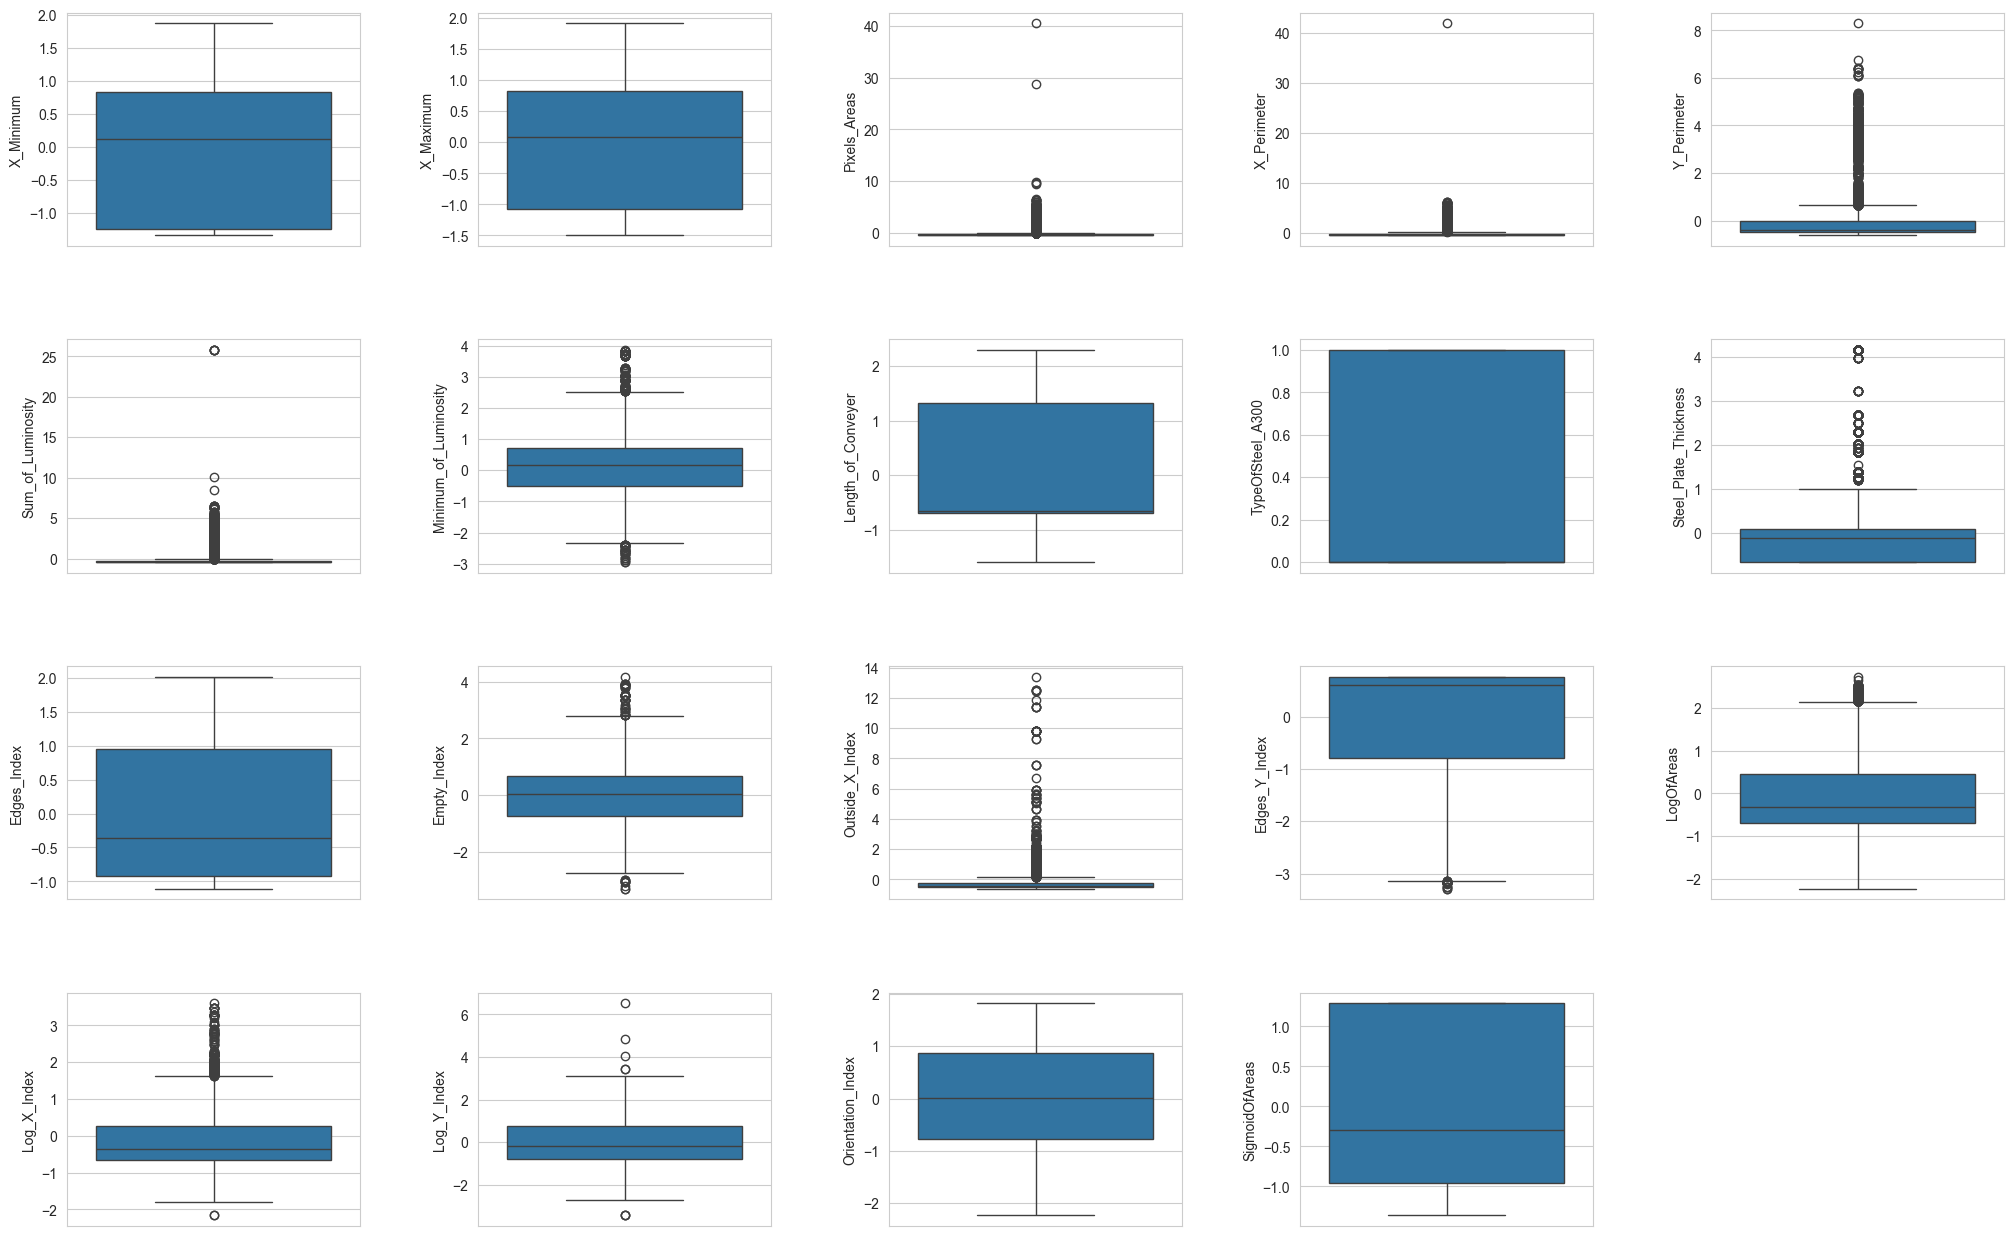

In [47]:
fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 5, i)
    sns.boxplot(train.iloc[:, i - 1], ax=ax)


In [48]:
np.quantile(train.iloc[:, 2], 0.9995, axis=0)

6.337158273784298

In [50]:
train = train[train.iloc[:, 2] < np.quantile(train.iloc[:, 2], 0.9995)]

In [51]:
train = train[train.iloc[:, 4] < np.quantile(train.iloc[:, 4], 0.999)]

In [52]:
train = train[train.iloc[:, 6] < np.quantile(train.iloc[:, 6], 0.999)]

In [53]:
train = train[train.iloc[:, 6] > np.quantile(train.iloc[:, 6], 0.001)]

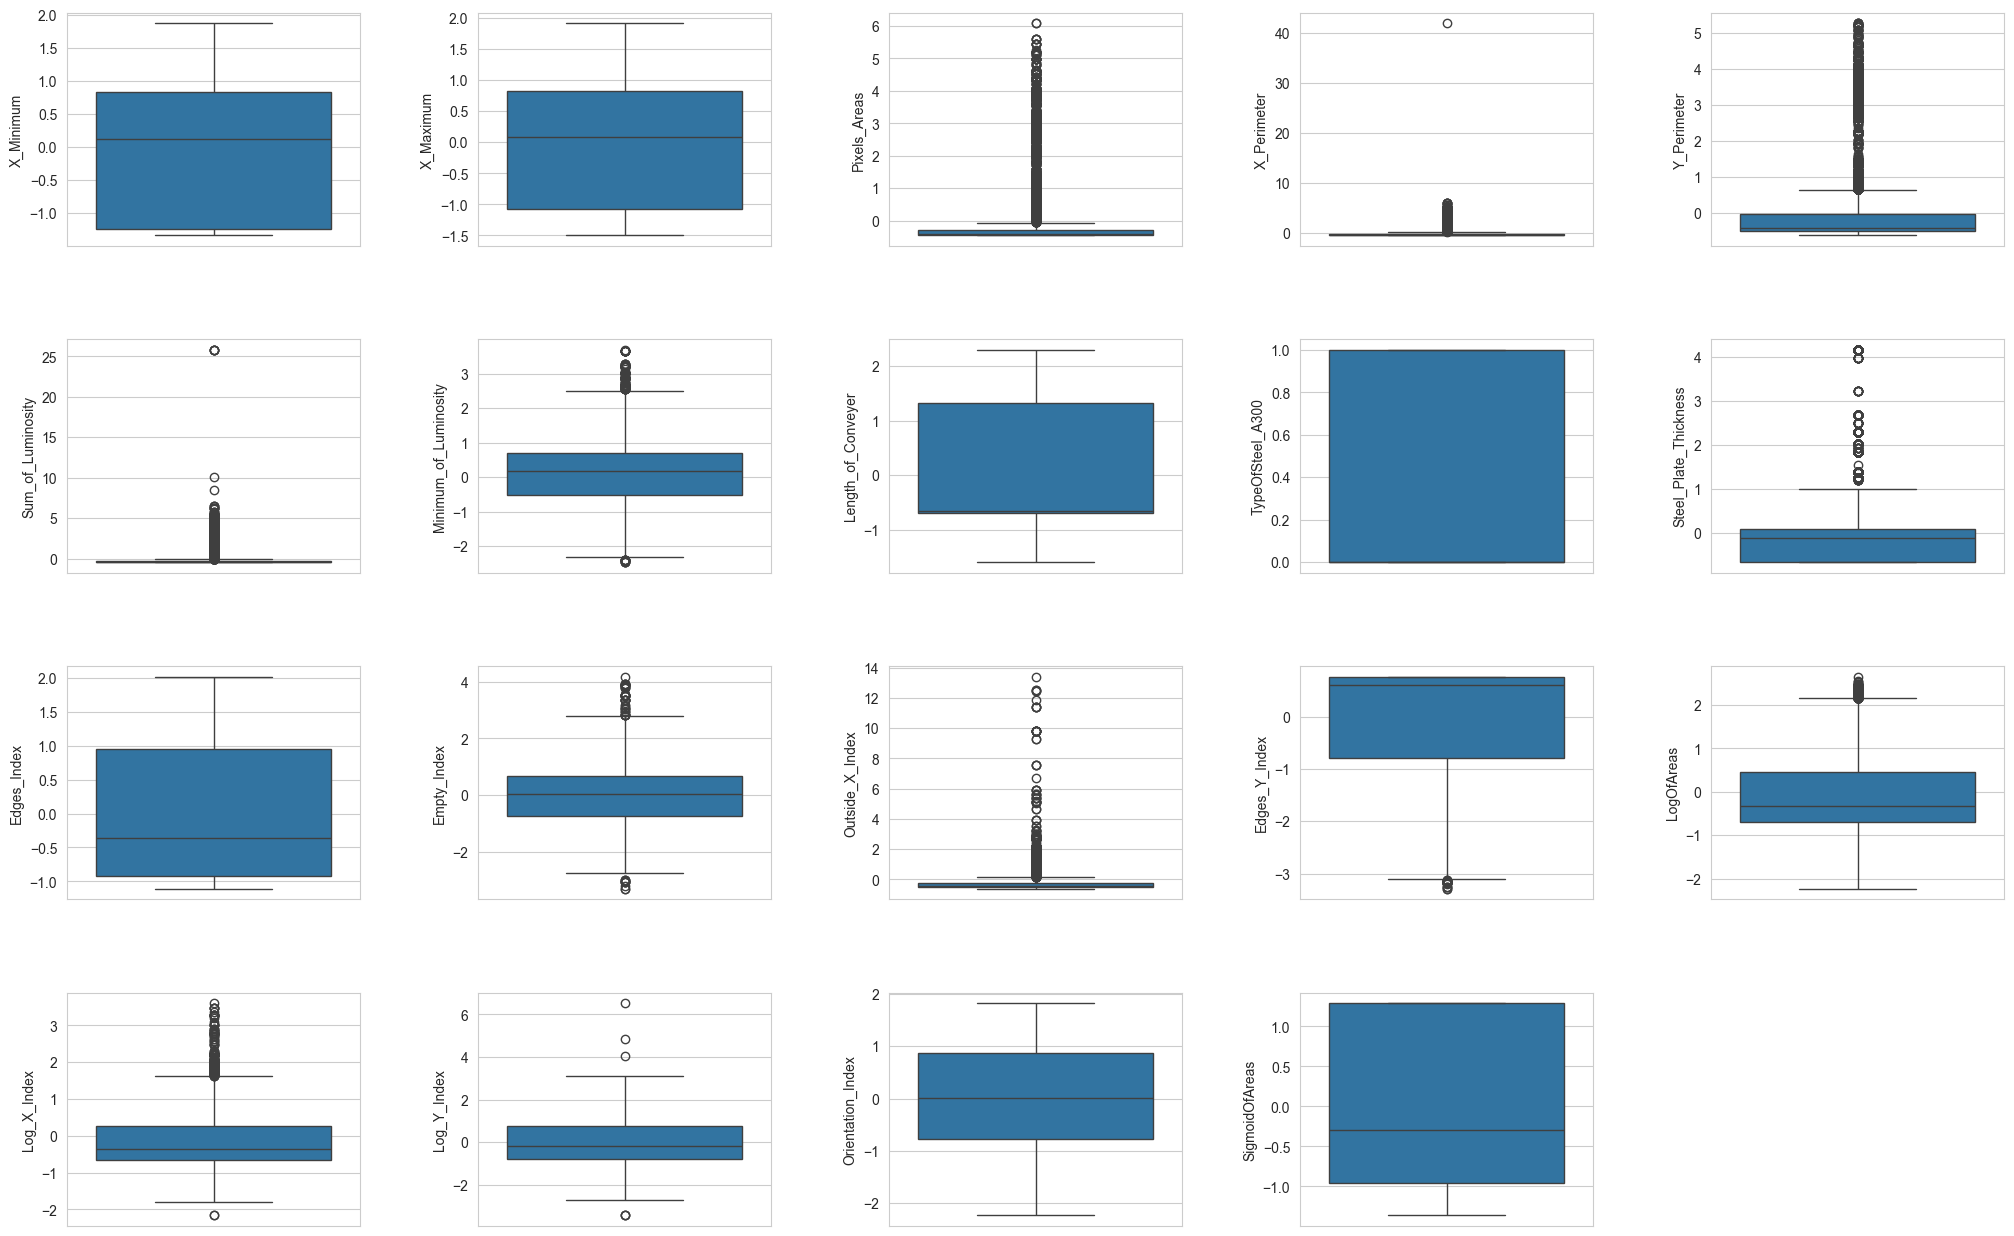

In [54]:
fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 5, i)
    sns.boxplot(train.iloc[:, i - 1], ax=ax)

In [55]:
train = train[train.iloc[:, 3] < np.quantile(train.iloc[:, 3], 0.9995)]

In [56]:
train = train[train.iloc[:, 5] < np.quantile(train.iloc[:, 5], 0.9995)]

In [57]:
train = train[train.iloc[:, 9] < np.quantile(train.iloc[:, 9], 0.9995)]

In [58]:
train = train[train.iloc[:, 11] < np.quantile(train.iloc[:, 11], 0.999)]
train = train[train.iloc[:, 11] > np.quantile(train.iloc[:, 11], 0.001)]

In [59]:
train = train[train.iloc[:, 12] < np.quantile(train.iloc[:, 12], 0.999)]

In [60]:
train = train[train.iloc[:, 13] > np.quantile(train.iloc[:, 13], 0.0005)]

In [61]:
train = train[train.iloc[:, 3] < np.quantile(train.iloc[:, 14], 0.9995)]

In [62]:
train = train[train.iloc[:, 15] < np.quantile(train.iloc[:, 15], 0.999)]
train = train[train.iloc[:, 15] > np.quantile(train.iloc[:, 15], 0.0005)]

In [63]:
train = train[train.iloc[:, 16] < np.quantile(train.iloc[:, 16], 0.9995)]
train = train[train.iloc[:, 16] > np.quantile(train.iloc[:, 16], 0.0005)]

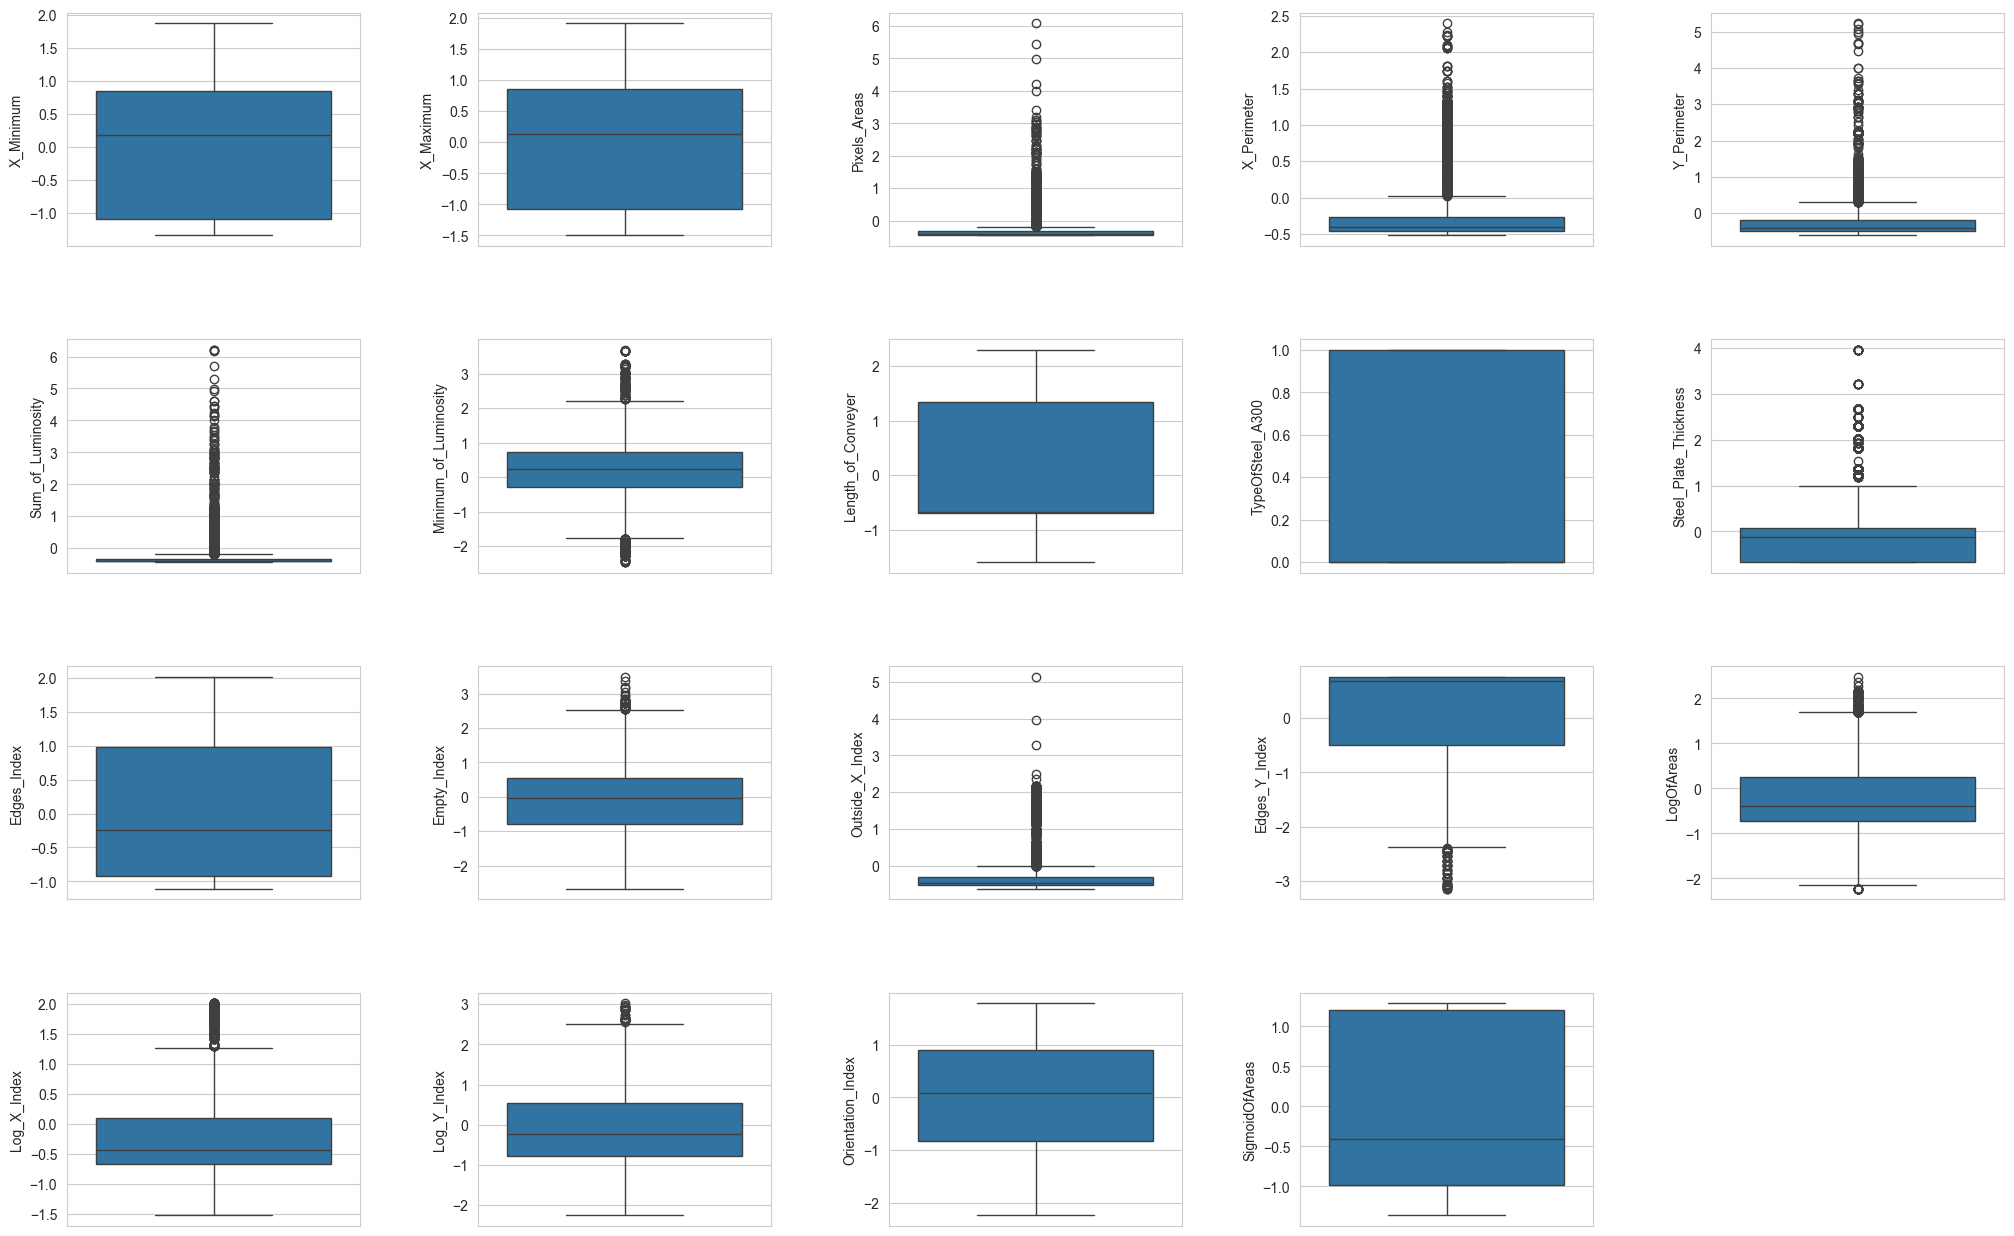

In [64]:
fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 5, i)
    sns.boxplot(train.iloc[:, i - 1], ax=ax)

In [65]:
train.to_csv("data/without_outliers_and_uncorrelated/train_cleaned.csv", index=False)
test.to_csv("data/without_outliers_and_uncorrelated/test_cleaned.csv", index=False)

In [73]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=["defect"]), train["defect"], test_size=0.2, random_state=42)

In [74]:
np.save("data/without_outliers_and_uncorrelated/X_train.npy", X_train)
np.save("data/without_outliers_and_uncorrelated/X_val.npy", X_val)
np.save("data/without_outliers_and_uncorrelated/X_test.npy", test.to_numpy())
np.save("data/without_outliers_and_uncorrelated/y_train.npy", y_train)
np.save("data/without_outliers_and_uncorrelated/y_val.npy", y_val)

In [77]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=weights)
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [10, 50, None],
    "learning_rate": [0.001, 0.01, 0.1],
    "subsample": [0.5, 0.7, 1.0]
}
xgb_score, xgb_params, xgb_model = model_train_and_tune(xgb_model, param_grid, X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
print_results(xgb_score, xgb_params)

In [ ]:
roc_auc_score(y_val, xgb_model.predict_proba(X_val), multi_class="ovr")